In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

load_dotenv()

f:\Gen AI Repos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive","negative"] = Field(description="Sentiment of the Review")

In [3]:
class DiagnosisSchema(BaseModel):

    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated","dissapointed","calm"] = Field(description="The emotional toneof the user.")
    urgency: Literal["low","medium","high"] = Field(description='How urgent or critical the issue appears to be')

In [4]:
model = ChatOpenAI(
    model="gpt-3.5-turbo"
)

structured_model_1 = model.with_structured_output(SentimentSchema)
strucutred_model_2 = model.with_structured_output(DiagnosisSchema)

f:\Gen AI Repos\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:2067: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [20]:
prompt = 'What is the sentiment of the following review - The software too good'
strucutred_model_2.invoke(prompt)

DiagnosisSchema(issue_type='Other', tone='calm', urgency='low')

In [5]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive","negative"]
    diagnosis: dict
    response: str

In [31]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review , Find out the sentiment \n {state["review"]}'

    sentiment = structured_model_1.invoke(prompt).sentiment

    return {"sentiment": sentiment}

In [32]:
def check_sentiment(state: ReviewState) -> Literal["positive_response","return_diagnosis"]:

    if state['sentiment'] == 'positive':
        return "positive_response"
    else:
        return "return_diagnosis"

In [33]:
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    result = model.invoke(prompt).content

    return {"response": result}

In [39]:
def return_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """

    result = strucutred_model_2.invoke(prompt).model_dump()

    return {"diagnosis": result}

In [40]:
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message."""

    result = model.invoke(prompt).content

    return {"response": result}


In [41]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("return_diagnosis",return_diagnosis)
graph.add_node("negative_response",negative_response)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("positive_response",END)
graph.add_edge("return_diagnosis","negative_response")
graph.add_edge("negative_response",END)

workflow = graph.compile()

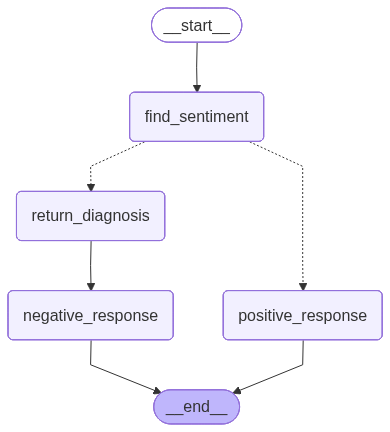

In [42]:
workflow

In [43]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "I'm truly sorry to hear about the bug issue you're facing. I can understand how frustrating it must be. Rest assured, I will do everything in my power to help resolve this issue for you as quickly as possible. Let's work together to troubleshoot and find a solution. Thank you for bringing this to our attention and for your patience."}